In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm
from scipy.stats import pearsonr
pd.set_option('display.max_columns',None)

In [65]:
nas_100 = pd.read_excel('nas100.xls', sheet_name=None)
nas_100 = pd.concat(nas_100.values(), ignore_index=True).dropna()
nas_100.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','volume','value']
#nas_100.set_index('date',drop=True,inplace=True)

In [66]:
nas_100.head()

,id,name,date,open,close,high,low,return,return_percent,pre_close,volume,value
911,AAPL.O,苹果,2017/10/25,156.91,156.41,157.55,155.27,-0.69,-0.4392,157.10,21175670.0,3.315909e+09
912,AAPL.O,苹果,2017/10/26,157.23,157.41,157.83,156.78,1.00,0.6393,156.41,16916650.0,2.676490e+09
913,AAPL.O,苹果,2017/10/27,159.29,163.05,163.60,158.70,5.64,3.5830,157.41,44387768.0,7.194351e+09
914,AAPL.O,苹果,2017/10/30,163.89,166.72,168.07,163.72,3.67,2.2508,163.05,44651420.0,7.449492e+09
915,AAPL.O,苹果,2017/10/31,167.90,169.04,169.65,166.94,2.32,1.3916,166.72,35779520.0,6.077042e+09


In [67]:
new_df = nas_100.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [68]:
length = 10

nas_100['vol_'] = nas_100.groupby('id')['return_percent'].rolling(length).std().shift(-length).values
nas_100['vol'] = nas_100['vol_']**2

#nas_100['vol'] = (nas_100['return_percent'])**2

In [82]:
def feature_cal(df):
    #return ((df['close']+df['close'])-(df['high']+df['low']))/df['close'].fillna(0)
    # return df['volume'].diff().fillna(0)
    #return df['value'].diff().fillna(0)
    #return df['return_percent'].rolling(length).std().diff().fillna(0)
    return (df['return_percent'])

In [83]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    corr = pearsonr(feature[:-1], small_df['vol'].shift(-1)[:-1])
    if (corr[1]) < 0.05:
        bestname.append(name)
    
len(bestname)

100%|██████████| 101/101 [00:00<00:00, 110.59it/s]


96

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:05<00:00, 19.18it/s]


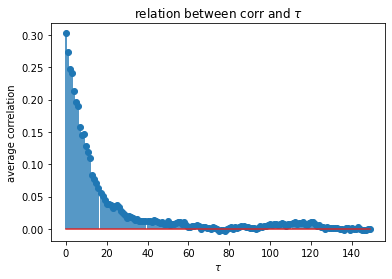

In [84]:
n = 150
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        try:
            pear = pearsonr(feature[:-i:3], small_df['vol'].shift(-i).fillna(0)[:-i:3])
        except ValueError:
            pear = (0, 1)
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)

plt.stem(range(n), np.array(l_corr_list))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

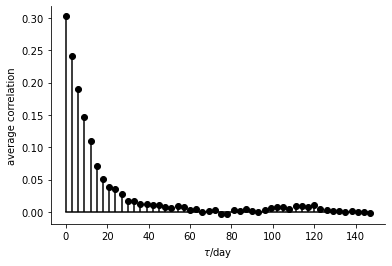

In [85]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

In [51]:
new_df_vol = nas_100.pivot(index='date', columns='id', values='vol').fillna(0)
new_df_resi = new_df.copy()
aver =  np.array(new_df_vol.T.mean()).reshape(-1,1)
for name in new_df_vol.columns:
    fit_y = new_df_vol[name]
    fit_x = aver
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

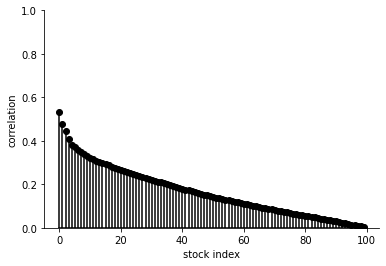

0.1658711611195295


In [78]:
stocks = new_df_resi.columns
corr_list_ = [0 for i in stocks]
for i in range(len(stocks)):
    corr_list = [abs(pearsonr(new_df_resi[stocks[i]],new_df_resi[stocks[j]])[0]) for j in range(len(stocks))]
    (corr_list).sort(reverse= True)
    for j in range(len(stocks)):
        corr_list_[j] += corr_list[j]/len(stocks)
plt.stem(range(len(stocks)-1), corr_list_[1:], linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('stock index')
plt.ylabel('correlation')
plt.ylim(0,1)
plt.show()
print(sum(corr_list_[1:])/(len(corr_list_)-1))

100%|██████████| 23/23 [00:00<00:00, 32.55it/s]


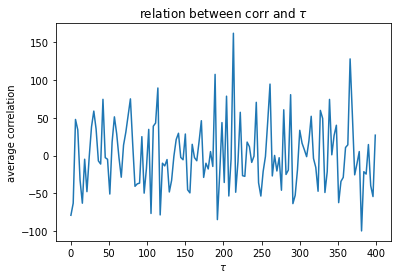

In [53]:
n = 400
step = 3
l_corr_list = [0 for i in range(0,n,step)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    
    X = np.array([feature.shift(j).fillna(0) for j in range(0,n,step)]).T
    Y = small_df['vol'].shift(-1).diff().fillna(0)
    model = LinearRegression()
    model.fit(X, Y)
    for i in range(len(l_corr_list)):
        l_corr_list[i] += model.coef_[i]#/np.sqrt(Y.std())*np.sqrt(X[i].std())
    # l_corr_list[i-1] += (pearsonr(feature[:-i], small_df['vol'].rolling(10).sum().shift(-i)[:-i].fillna(0))[0])/len(bestname)

plt.plot(range(0,n,step), np.array(l_corr_list))
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 31.90it/s]


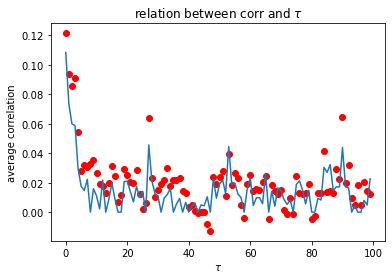

In [54]:
n = 100
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        try:
            pear = pearsonr(feature[:-i:3], small_df['volume'].shift(-i)[:-i:3])
        except ValueError:
            pear = (0, 1)
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)

plt.plot(range(n), np.array(l_corr_list))
plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
plt.title(r'relation between corr and $\tau$')
plt.show()

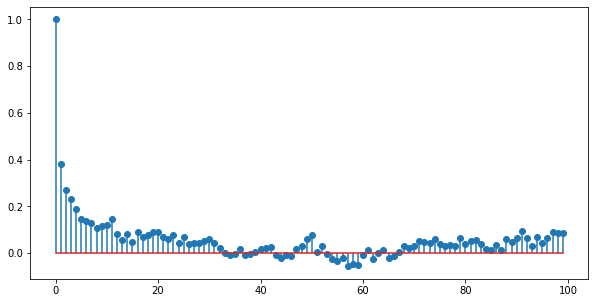

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

small_df = nas_100[nas_100['id']==test_names[1]].copy().dropna()
series = pd.Series(small_df['volume'])

autocorrelation = series.autocorr()

# 计算不同滞后阶数的自相关系数
lags = range(100)
autocorrelations = [series.autocorr(lag) for lag in lags]

plt.figure(figsize=(10, 5))
plt.stem(lags, autocorrelations)
plt.show()

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:01<00:00, 21.09it/s]


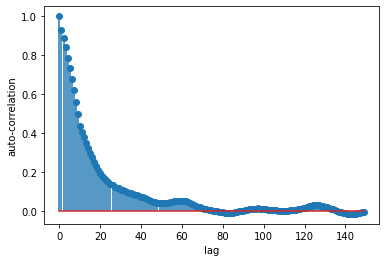

In [79]:
n = 150
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = nas_100[nas_100['id']==name].copy().dropna()
    series = pd.Series(small_df['vol'].fillna(0))

    autocorrelation = series.autocorr()

    # 计算不同滞后阶数的自相关系数
    lags = range(n)
    for lag in lags:
        l_corr_list[lag] += series.autocorr(lag)/len(test_names)

plt.stem(range(n), np.array(l_corr_list))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'lag')
plt.ylabel('auto-correlation')
#plt.title(r'auto')
plt.show()

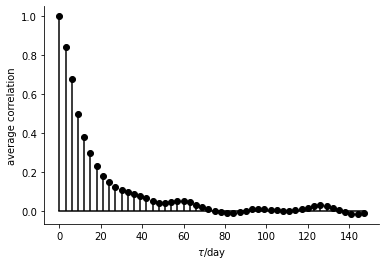

In [81]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

# 个股

In [58]:
nas_100['vwap'] = nas_100['value']/(nas_100['volume']+.00001)

In [59]:
def feature_cal(df):
    return ((df['vwap']+df['vwap'])-(df['high']+df['low']))/df['close'].fillna(0)

In [60]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = nas_100[nas_100['id']==name].copy()
    feature = feature_cal(small_df)
    corr = pearsonr(feature, small_df['return_percent'].shift(-1).fillna(0))
    if (corr[1]) < 0.001:
        bestname.append(name)
    
len(bestname)

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 124.17it/s]


1

100%|██████████| 1/1 [00:00<00:00, 52.87it/s]


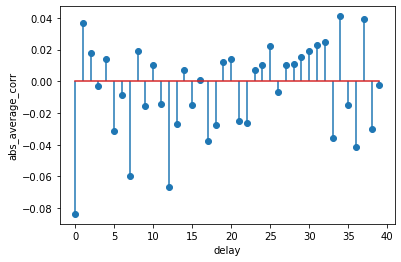

In [61]:
n = 40
l_corr_list = [0 for i in range(n)]
name_list = bestname

for name in tqdm(name_list):
    small_df = nas_100[nas_100['id']==name].copy()
    feature = feature_cal(small_df)
    for i in range(1, n+1):
        l_corr_list[i-1] += (pearsonr(feature, small_df['return_percent'].shift(-i).fillna(0))[0])/len(name_list)

plt.stem(range(n), np.array(l_corr_list))
plt.xlabel('delay')
plt.ylabel('abs_average_corr')
plt.show()